- Load Files

In [1]:
import pandas as pd

train = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13840 entries, 0 to 13839
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              13840 non-null  int64  
 1   Gender                          13840 non-null  object 
 2   Age                             13840 non-null  float64
 3   Height                          13840 non-null  float64
 4   Weight                          13840 non-null  float64
 5   family_history_with_overweight  13840 non-null  object 
 6   FAVC                            13840 non-null  object 
 7   FCVC                            13840 non-null  float64
 8   NCP                             13840 non-null  float64
 9   CAEC                            13840 non-null  object 
 10  SMOKE                           13840 non-null  object 
 11  CH2O                            13840 non-null  float64
 12  SCC                             

- Define numerical & categorical columns

In [4]:
numerical_columns = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

In [5]:
categorical_columns = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

- Capped Outliers

In [6]:
# Define a function to cap outliers based on the IQR method
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap the outliers
    df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

# Apply the capping function to both train and test datasets
for column in numerical_columns:
    cap_outliers(train, column)
    cap_outliers(test, column)

- One Hot Encoding

In [7]:
train_df_encoded = pd.get_dummies(train, columns=categorical_columns, drop_first=True)
test_df_encoded = pd.get_dummies(test, columns=categorical_columns, drop_first=True)

In [8]:
# Align the columns of test dataset with train dataset (excluding target column)
test_df_encoded = test_df_encoded.reindex(columns=train_df_encoded.columns.drop('NObeyesdad'), fill_value=0)

- Setup features and target

In [9]:
X = train_df_encoded.drop(columns=['id', 'NObeyesdad'])
y = train_df_encoded['NObeyesdad']

- Train test split with stratify

In [10]:
from sklearn.model_selection import train_test_split

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [11]:
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
y_encoded = LabelEncoder().fit_transform(y)

- Train Xgboost Model

In [12]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import numpy as np


# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Initialize the model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_encoded)))

accuracies = []

for train_index, val_index in kf.split(X):
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y_encoded[train_index], y_encoded[val_index]

    # Scale the features
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    # Train the model
    model.fit(X_train_fold_scaled, y_train_fold)

    # Make predictions on the validation set
    y_val_pred = model.predict(X_val_fold_scaled)

    # Evaluate accuracy
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    accuracies.append(accuracy)

# Calculate the average accuracy
average_accuracy = np.mean(accuracies)

- Predict on test data

In [13]:
# Scale the test dataset
X_test_scaled = scaler.transform(test_df_encoded.drop(columns=['id']))

In [14]:
# Make predictions on the test dataset
test_predictions = model.predict(X_test_scaled)

In [15]:
# Decode the predictions back to the original labels
test_predictions_decoded = LabelEncoder().fit(y).inverse_transform(test_predictions)
test_predictions_decoded

array(['Obesity_Type_II', 'Overweight_Level_I', 'Obesity_Type_III', ...,
       'Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_II'],
      dtype=object)

- Create a submission DataFrame

In [16]:
submission = test[['id']].copy()

In [17]:
submission['NObeyesdad'] = test_predictions_decoded

In [18]:
submission.head()

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III


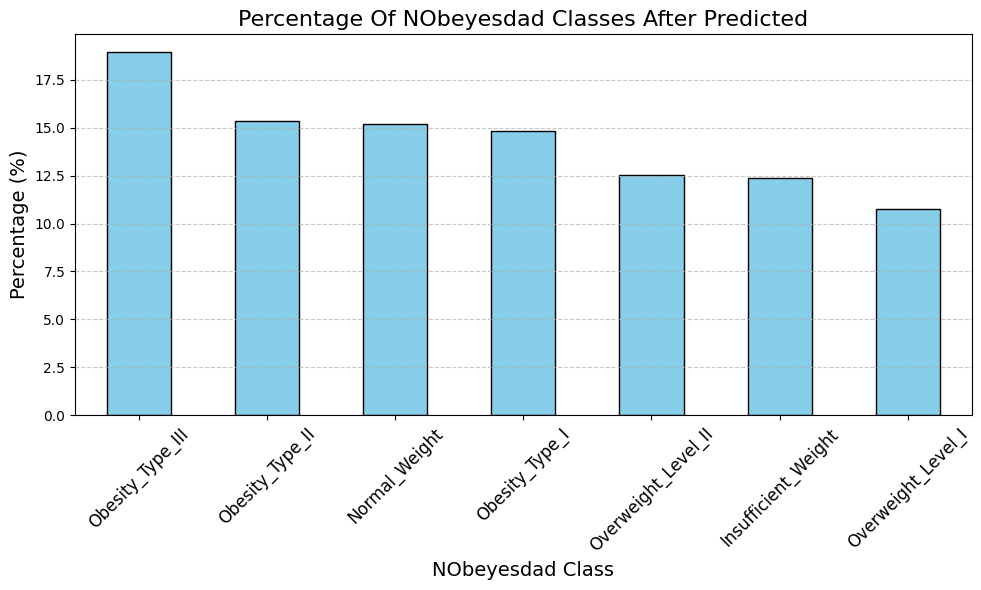

In [19]:
import matplotlib.pyplot as plt

# Calculate the percentage of each class in the submission
class_percentages = submission['NObeyesdad'].value_counts(normalize=True) * 100

# Plot the percentages
plt.figure(figsize=(10, 6))
class_percentages.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Percentage Of NObeyesdad Classes After Predicted', fontsize=16)
plt.xlabel('NObeyesdad Class', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- From results :

- High Levels : `Obesity_Type_III` and  `Obesity_Type_II` represent varying levels of obesity severity, which are directly linked to increased cardiovascular risk.

- Normal and Overweight Levels : Predictions for `Normal_Weight` and `Overweight_Level_I/II` provide insights into individuals with lower or moderate risk. It classified the normal weight are at the lowest risk for obesity-related cardiovascular issues.

- `Overweight_Level_II` individuals are at an intermediate risk. 

In [20]:
# Save DataFrame to a CSV file
output_csv_path = 'submission.csv'
submission.to_csv(output_csv_path, index=False)